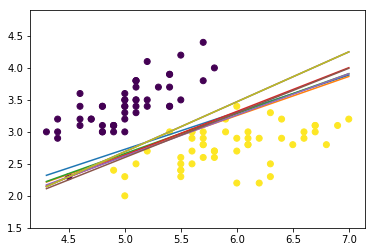

In [24]:
import sklearn
from sklearn.datasets import make_blobs, make_classification
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy

from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

T = 100


def load_data_set():
    # X, y = make_classification(n_features=2, n_redundant=0, n_clusters_per_class=1, n_classes=N_CLASSES)
    # plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

    # X, y = make_blobs(n_features=2, centers=N_CLASSES)
    # plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

    data_set = sklearn.datasets.load_iris()
    X = data_set['data'][:100, :2]
    y = data_set['target'][:100]

    y = [-1 if y[k] == 0 else 1 for k in range(len(y))]

    global LEFT, RIGHT, BOTTOM, TOP
    LEFT = min(X[:, 0])
    RIGHT = max(X[:, 0])
    BOTTOM = min(X[:, 1]) - 0.5
    TOP = max(X[:, 1]) + 0.5

    return X, y


def misclassified_points(X, y, beta):
    return [i for i in range(X.shape[0]) if y[i] * np.dot(beta, X[i].T) < 0]


def plot_boundary(beta, graph_type):
    x1 = sy.Symbol('x1')
    x2 = sy.Symbol('x2')
    gt = {"linear": (1, x1, x2), "quadratic": (1, x1, x2, x1*x1)}
    x = np.array(gt[graph_type]).T
    eq = np.dot(beta, x)
    equation = sy.solve(eq[0], x2)
    lam_f = sy.lambdify(x1, equation[0])
    x_vals = np.linspace(LEFT, RIGHT, num=100)
    plt.gca().set_ylim([BOTTOM, TOP])
    line, = plt.plot(x_vals, lam_f(x_vals))
    return line


def param_gradient_descent(X, y, beta, Lambda):

    for i in range(T):
        misclassif = misclassified_points(X, y, beta)
        val = sum(y[i] * X[i] for i in misclassif)
        beta += Lambda * val
    return beta


def split_train_test(X_s, y_s, i):
    X_train = np.concatenate([X_s[j] for j in range(5) if j != i])
    y_train = np.concatenate([y_s[j] for j in range(5) if j != i])
    return X_train, X_s[i], y_train, y_s[i]


def compute_error():
    X, y = load_data_set()
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
    X = np.insert(X, 0, 1, axis=1)
    
    X_s = np.split(X, 5)
    y_s = np.split(np.array(y), 5)
    beta = np.random.rand(1, X.shape[1])
    
    data_matrix = [['Lambda', 'Error - train', 'Error - test']]

    for lambda_var in np.arange(0.01, 0.1, 0.01):
        err_train = 0
        err_test = 0
        best_beta = None
        best_err = 1.1
        for i in range(5):
            X_train, X_test, y_train, y_test = split_train_test(X_s, y_s, i)
            beta = param_gradient_descent(X_train, y_train, beta, lambda_var)       
            err_train += len(misclassified_points(X_train, y_train, beta)) / len(y_train)
            err_test += len(misclassified_points(X_test, y_test, beta)) / len(y_test)
            if err_test < best_err:
                best_beta = beta
        plot_boundary(best_beta, 'linear')
            
        data_matrix.append([str(lambda_var), str(err_train / 5), str(err_test / 5)])

    table = ff.create_table(data_matrix)
    iplot(table, filename='error_table')
    plt.show()
    
compute_error()
